# Pneumonia X-Ray Classifier with PyTorch and Keras CNN Model

In this code we will be creating a deep learning neural network with the convolutional neural network (CNN).

##Setting up the Spark

In [2]:
# First we will set up the Spark session

!pip install -q pyspark

appname = "Pneumonia X Ray Classifier"

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

## Setting up the Data

In [1]:
# Setting up and downloading the data from kaggle

!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json
import kagglehub

Mounted at /content/drive


Saving kaggle.json to kaggle.json
{"username":"elizabethkwon","key":"892ee8c44a85dd1ba99a9e518e949f8b"}

In [3]:
imagepath = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
import os
data_path = os.path.join(imagepath, 'chest_xray')
print(os.listdir(data_path))

100%|██████████| 2.29G/2.29G [00:33<00:00, 74.5MB/s]

Extracting files...


['train', 'val', 'chest_xray', '__MACOSX', 'test']


In [4]:
# This function is for creating the list of images with the label (either pneumonia or normal, given the file pathway)

def file_list(directory, label, targetlist):
    for file in os.listdir(directory):
        if file.lower().endswith('.jpeg'):  # Include only .jpeg files
            targetlist.append([os.path.join(directory, file), label])

In [5]:
import numpy as np
from PIL import Image

# This function is for the preprocessing of the images, changing from rbg --> grayscale and normalizing the pixesl.
def processingimg(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path).convert('L')
        image_resized = img.resize(target_size)
        return np.array(image_resized).astype('float32') / 255.0
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# This functino creates a spark dataframe, calling on the preprocessingimg function
def compose_dataset_spark(sparkdf, target_size=(224, 224)):
    images = []
    labels = []

    for row in sparkdf.collect():
        img_array = processingimg(row.image, target_size)
        if img_array is not None:
            images.append(img_array)
            labels.append(row.label)

    images = np.array(images).reshape(-1, target_size[0], target_size[1], 1)  # Add channel dimension
    labels = np.array(labels)

    return images, labels

First, we made the images and the labels into a list. This list was then randomized to avoid biases in the model's learning.

In [6]:
train_path_p = os.path.join(data_path, 'train/PNEUMONIA')
train_path_n = os.path.join(data_path, 'train/NORMAL')
val_path_p = os.path.join(data_path, 'val/PNEUMONIA')
val_path_n = os.path.join(data_path, 'val/NORMAL')
test_path_p = os.path.join(data_path, 'test/PNEUMONIA')
test_path_n = os.path.join(data_path, 'test/NORMAL')

trainlist = []
testlist = []
vallist = []

# Here we are labeling 0 for normal and 1 for pneumonia
file_list(train_path_n, 0, trainlist)
file_list(train_path_p, 1, trainlist)
file_list(test_path_n, 0, testlist)
file_list(test_path_p, 1, testlist)
file_list(val_path_n, 0, vallist)
file_list(val_path_p, 1, vallist)

# here we are randomly shuffling the list so that the model doesn't learn /
## patterns based on the groupings on the order of the list.
import random as rn
rn.shuffle(trainlist)
rn.shuffle(testlist)
rn.shuffle(vallist)

The lists were then turned into spark dataframes with two columns: the image and the label.

There were 5216 images total in the train dataset, 624 in the test set, and 16 in the validation set.

In [7]:
# Create Spark DataFrames
trainimage_df = spark.createDataFrame(trainlist, ["image", "label"])
testimage_df = spark.createDataFrame(testlist, ["image", "label"])
valimage_df = spark.createDataFrame(vallist, ["image", "label"])

# Applying functions to datasets (train, test, validation)
X_train, y_train = compose_dataset_spark(trainimage_df)
X_test, y_test = compose_dataset_spark(testimage_df)
X_val, y_val = compose_dataset_spark(valimage_df)

# Print dataset shapes
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)


##Building the model with Keras / Tensorflow

This model requires installation of tensorflow and keras.

In [8]:
!pip install tensorflow

In [9]:
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers

Next we will create the CNN model.

In [10]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your model
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # 4th Convolution
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattened the layer
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    return model




In [11]:
model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/keras version/model_at_epoch_{epoch}.keras"),
]


In [15]:
# Note: this code should only be run once.

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [16]:
batch_size = 128
nb_epoch = 10

history1 = model.fit(
    X_train,  # Training data
    y_train,  # Labels
    validation_data=(X_val, y_val),  # Separate validation data
    batch_size=batch_size,
    epochs=nb_epoch,
    callbacks=callbacks  # Any callbacks like checkpointing or early stopping
)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 470ms/step - accuracy: 0.6967 - loss: 0.6015 - val_accuracy: 0.6250 - val_loss: 1.1592
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - accuracy: 0.9017 - loss: 0.2304 - val_accuracy: 0.6875 - val_loss: 1.0159
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9270 - loss: 0.1701 - val_accuracy: 0.6875 - val_loss: 0.6475
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9538 - loss: 0.1367 - val_accuracy: 0.6875 - val_loss: 0.5067
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9585 - loss: 0.1189 - val_accuracy: 0.9375 - val_loss: 0.1847
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9651 - loss: 0.0981 - val_accuracy: 0.9375 - val_loss: 0.3008
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9734 - loss: 0.0901 - val_accuracy: 0.9375 - val_loss: 0.1680
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9772 - loss: 0.0768 - val_accuracy

##Evaluation and visualization of the model

Now we will visualize the accuracy and loss for each epoch, and evaluate the model using the test set.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualizing_model(history):

    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(7,7))

    # Loss plot
    epochs = range(1, len(val_loss_values) + 1)
    sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Training Loss')
    sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Validation Loss')
    axis[0].set(xlabel='Epochs', ylabel='Loss')
    axis[0].set_title('Model Loss', fontsize=20)
    axis[0].grid(True)  # Correct grid call

    # Accuracy plot
    sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Training Accuracy')
    sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Validation Accuracy')
    axis[1].set(xlabel='Epochs', ylabel='Accuracy')
    axis[1].set_title('Model Accuracy', fontsize=20)
    axis[1].grid(True)  # Correct grid call

    plt.tight_layout()
    plt.show()


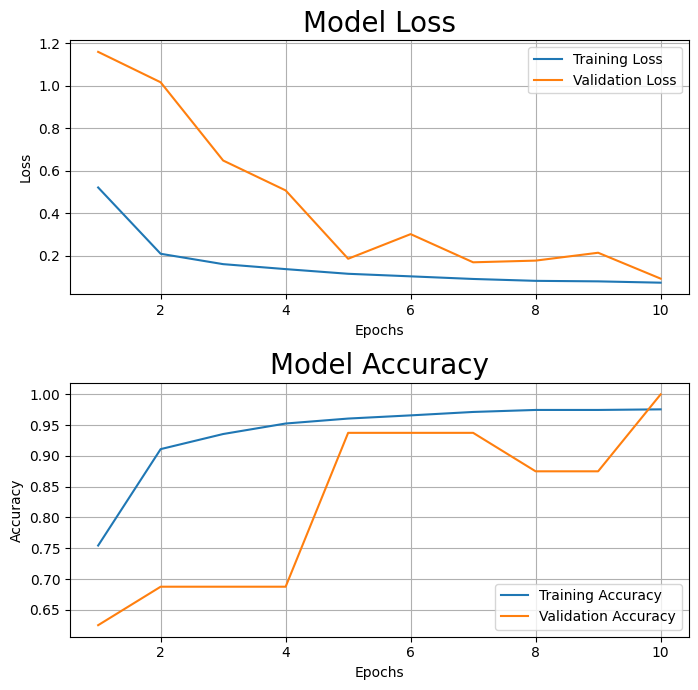

In [21]:
visualizing_model(history1)


According to the visualization, it seems like the validation accuracy is generally on an upwards increase with more epochs, and the model loss is generally decreasing with more epochs.

We are saving the model to the desired path.

In [22]:
model.save("/content/drive/MyDrive/Colab Notebooks/keras version/finalmodel.keras")
model = keras.saving.load_model("/content/drive/MyDrive/Colab Notebooks/keras version/finalmodel.keras")

In [23]:
predictions = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 81.57%


The model showed a 81.57% accuracy for our random seed, indicating that this is a decent prediction model for classifying pneumonia and normal chest X-rays.